# **Setting up the environment**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pathlib import Path

path = Path("/kaggle/input/california-boarding/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [4]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


# **Ridership figures for 3 months**

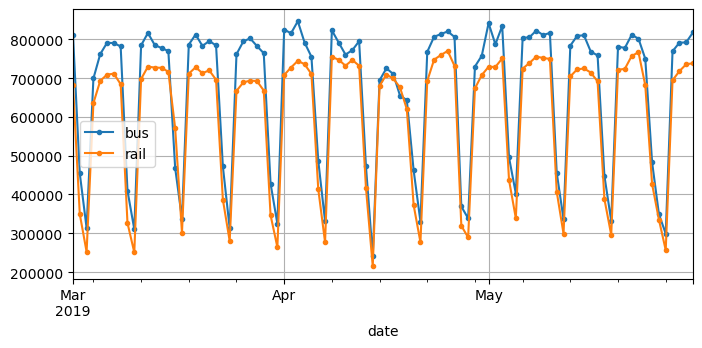

In [5]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

# **Week differencing**

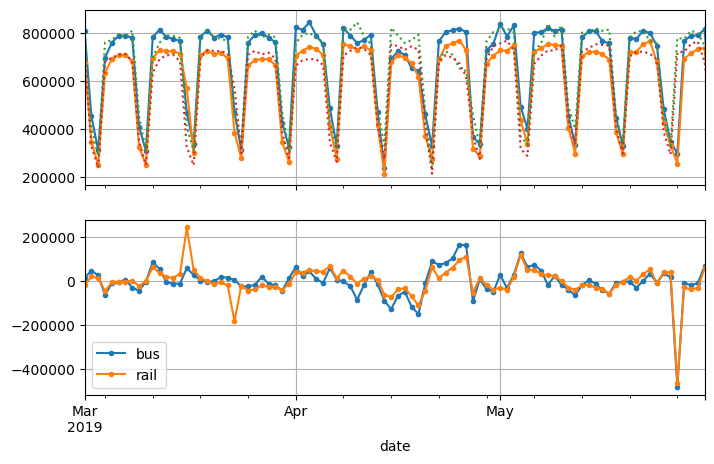

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
axs[0].set_ylim([170_000, 900_000])
plt.show()

In [7]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

In [10]:
# Our naive forecasts has a mape of roughly 8.3% for bus and 9.0% for rail

# **Trend & Seasonality**

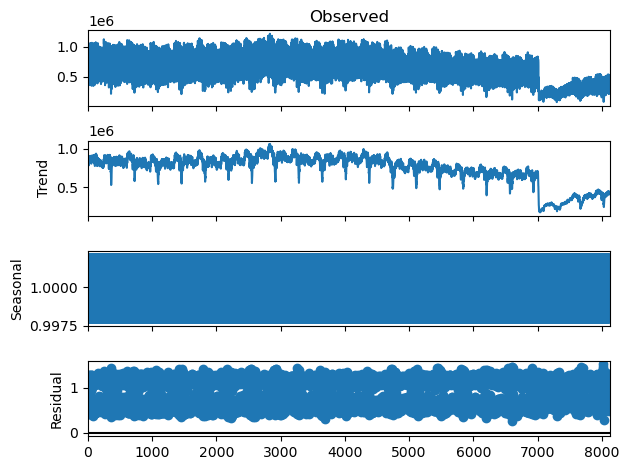

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompse = seasonal_decompose(np.array(df['bus']), 
model='multiplicative', period = 12)
plot = decompse.plot()

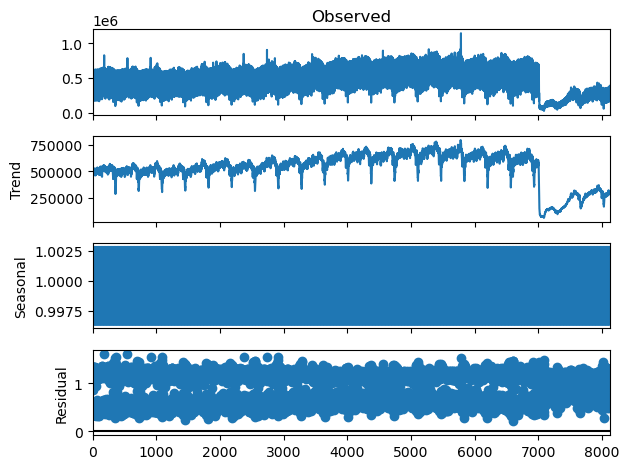

In [12]:
decompse = seasonal_decompose(np.array(df['rail']), 
model='multiplicative', period = 12)
plot = decompse.plot()

# **Year differencing**

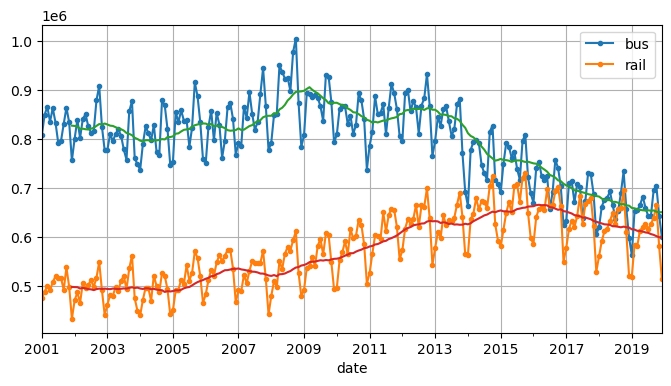

In [13]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

plt.show()

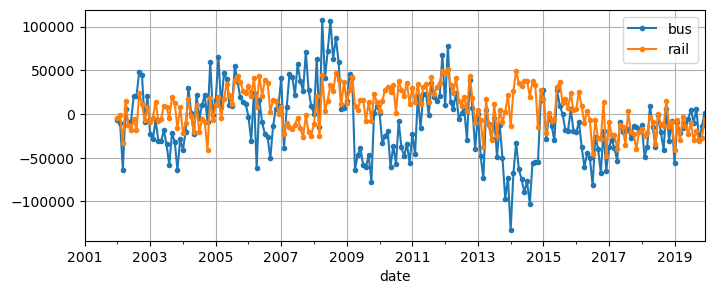

In [14]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

# **ARMA Model Family**

In [15]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()

In [16]:
y_pred[0]

427758.62641035335

In [17]:
df["rail"].loc["2019-06-01"]

379044

In [18]:
df["rail"].loc["2019-05-25"] # naive forecast (value from one week earlier)

426932

In [19]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()

In [20]:
mae

32040.720089453378

# **SARIMA Forecasts**

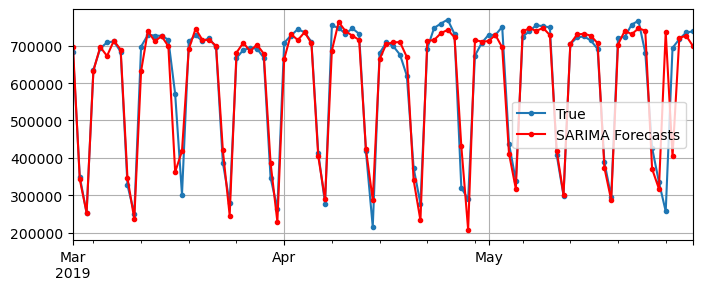

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

# **ACF & PACF**

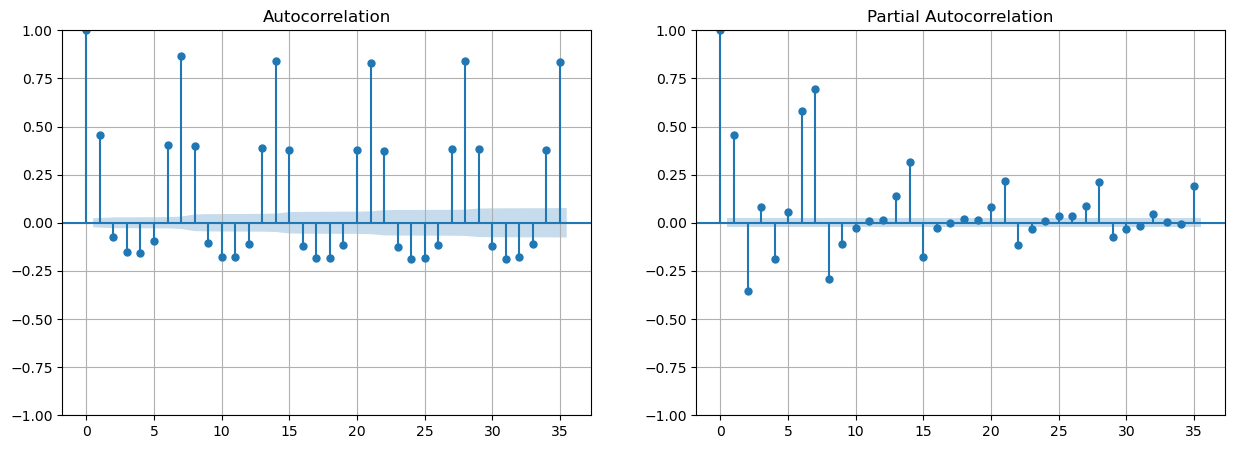

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

# **Modelling**

In [23]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [24]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [25]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

# **SimpleRNN**

In [26]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [27]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/100
33/33 [==============================] - 2s 19ms/step - loss: 0.0267 - mae: 0.1633 - val_loss: 0.0034 - val_mae: 0.0619
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0051 - mae: 0.0736 - val_loss: 0.0027 - val_mae: 0.0552
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0039 - mae: 0.0607 - val_loss: 0.0020 - val_mae: 0.0380
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0032 - mae: 0.0511 - val_loss: 0.0023 - val_mae: 0.0409
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0504 - val_loss: 0.0025 - val_mae: 0.0486
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0034 - mae: 0.0526 - val_loss: 0.0021 - val_mae: 0.0349
Epoch 7/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0033 - mae: 0.0508 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 8/100
33/33 [==============================] - 0s 12ms/step - loss: 0.

36661.00278496742

# **DeepRNN**

In [28]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [29]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/100
33/33 [==============================] - 3s 29ms/step - loss: 0.0541 - mae: 0.2327 - val_loss: 0.0167 - val_mae: 0.1218
Epoch 2/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0169 - mae: 0.1541 - val_loss: 0.0144 - val_mae: 0.1591
Epoch 3/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0154 - mae: 0.1521 - val_loss: 0.0153 - val_mae: 0.1159
Epoch 4/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0157 - mae: 0.1504 - val_loss: 0.0145 - val_mae: 0.1145
Epoch 5/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0137 - mae: 0.1428 - val_loss: 0.0121 - val_mae: 0.1275
Epoch 6/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0133 - mae: 0.1415 - val_loss: 0.0113 - val_mae: 0.1335
Epoch 7/100
33/33 [==============================] - 1s 21ms/step - loss: 0.0147 - mae: 0.1452 - val_loss: 0.0146 - val_mae: 0.1154
Epoch 8/100
33/33 [==============================] - 1s 19ms/step - loss: 0.

45724.36586022377

# **Multivariate time data forecasting**

In [30]:
df_mulvar = df[["bus", "rail"]] / 1e6  
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [31]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [32]:
tf.random.set_seed(42)
seq_length = 56
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  
    targets=mulvar_train[["bus","rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus","rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# **SimpleRNN**

In [33]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

In [34]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0350 - mae: 0.1913 - val_loss: 0.0092 - val_mae: 0.1119
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0040 - mae: 0.0652 - val_loss: 0.0013 - val_mae: 0.0403
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0460 - val_loss: 8.2925e-04 - val_mae: 0.0299
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0433 - val_loss: 0.0011 - val_mae: 0.0357
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0019 - mae: 0.0419 - val_loss: 0.0015 - val_mae: 0.0429
Epoch 6/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0018 - mae: 0.0416 - val_loss: 8.3142e-04 - val_mae: 0.0297
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0017 - mae: 0.0401 - val_loss: 7.0372e-04 - val_mae: 0.0265
Epoch 8/100
33/33 [==============================] - 0s 12ms/ste

25752.13834643364

In [35]:
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 22ms/step


# **Forecasting Several time steps ahead**

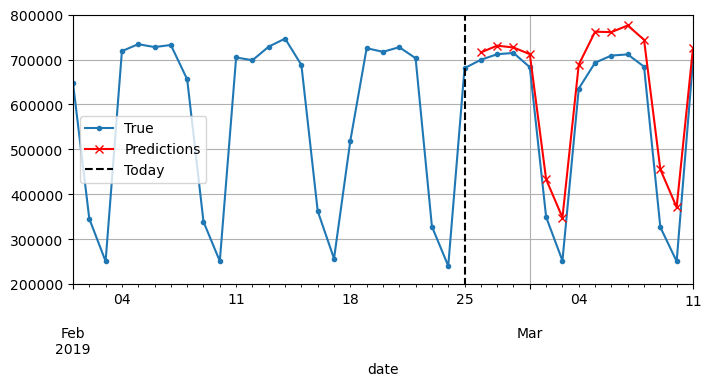

In [36]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
plt.show()

In [37]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

# **SimpleRNN**

In [38]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [39]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/100
33/33 [==============================] - 1s 18ms/step - loss: 0.1374 - mae: 0.3957 - val_loss: 0.0337 - val_mae: 0.1997
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0234 - mae: 0.1669 - val_loss: 0.0146 - val_mae: 0.1328
Epoch 3/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0144 - mae: 0.1306 - val_loss: 0.0098 - val_mae: 0.1081
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0110 - mae: 0.1130 - val_loss: 0.0073 - val_mae: 0.0935
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0091 - mae: 0.1006 - val_loss: 0.0060 - val_mae: 0.0840
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0079 - mae: 0.0920 - val_loss: 0.0049 - val_mae: 0.0763
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0071 - mae: 0.0858 - val_loss: 0.0042 - val_mae: 0.0701
Epoch 8/100
33/33 [==============================] - 0s 11ms/step - loss: 0.

35293.5716509819

# **Sequence to Sequence models**

In [40]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [41]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [42]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [43]:
tf.random.set_seed(42) 
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [44]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 2s 30ms/step - loss: 0.0637 - mae: 0.2618 - val_loss: 0.0146 - val_mae: 0.1294
Epoch 2/100
33/33 [==============================] - 1s 14ms/step - loss: 0.0098 - mae: 0.1044 - val_loss: 0.0078 - val_mae: 0.0887
Epoch 3/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0071 - mae: 0.0861 - val_loss: 0.0068 - val_mae: 0.0810
Epoch 4/100
33/33 [==============================] - 1s 14ms/step - loss: 0.0062 - mae: 0.0784 - val_loss: 0.0061 - val_mae: 0.0752
Epoch 5/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0056 - mae: 0.0729 - val_loss: 0.0053 - val_mae: 0.0685
Epoch 6/100
33/33 [==============================] - 1s 13ms/step - loss: 0.0052 - mae: 0.0696 - val_loss: 0.0053 - val_mae: 0.0688
Epoch 7/100
33/33 [==============================] - 1s 14ms/step - loss: 0.0050 - mae: 0.0669 - val_loss: 0.0049 - val_mae: 0.0639
Epoch 8/100
33/33 [==============================] - 1s 14ms/step - loss: 0.

48274.703323841095

# **Handling Long sequences**

In [45]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [46]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [47]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=100)

Epoch 1/100
33/33 [==============================] - 3s 36ms/step - loss: 0.0740 - mae: 0.2690 - val_loss: 0.0173 - val_mae: 0.1425
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0133 - mae: 0.1329 - val_loss: 0.0138 - val_mae: 0.1190
Epoch 3/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0107 - mae: 0.1166 - val_loss: 0.0118 - val_mae: 0.1100
Epoch 4/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0095 - mae: 0.1073 - val_loss: 0.0104 - val_mae: 0.1030
Epoch 5/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0087 - mae: 0.1005 - val_loss: 0.0096 - val_mae: 0.0982
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0081 - mae: 0.0956 - val_loss: 0.0092 - val_mae: 0.0959
Epoch 7/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0077 - mae: 0.0919 - val_loss: 0.0084 - val_mae: 0.0922
Epoch 8/100
33/33 [==============================] - 1s 25ms/step - loss: 0.

48840.69785475731

# **LSTM**

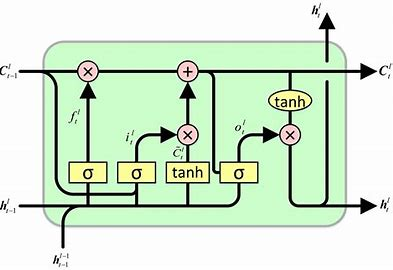

In [48]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [49]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 3s 40ms/step - loss: 0.0579 - mae: 0.2581 - val_loss: 0.0181 - val_mae: 0.1676
Epoch 2/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0168 - mae: 0.1574 - val_loss: 0.0170 - val_mae: 0.1451
Epoch 3/100
33/33 [==============================] - 1s 24ms/step - loss: 0.0151 - mae: 0.1488 - val_loss: 0.0160 - val_mae: 0.1416
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0144 - mae: 0.1447 - val_loss: 0.0154 - val_mae: 0.1369
Epoch 5/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0138 - mae: 0.1402 - val_loss: 0.0147 - val_mae: 0.1335
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0132 - mae: 0.1361 - val_loss: 0.0141 - val_mae: 0.1309
Epoch 7/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0127 - mae: 0.1329 - val_loss: 0.0136 - val_mae: 0.1275
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 0.

71684.0997338295

# **GRU**

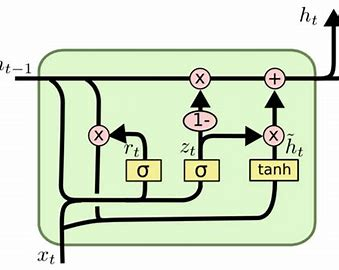

In [50]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [51]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/100
33/33 [==============================] - 4s 56ms/step - loss: 0.0526 - mae: 0.2501 - val_loss: 0.0183 - val_mae: 0.1619
Epoch 2/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0152 - mae: 0.1453 - val_loss: 0.0148 - val_mae: 0.1340
Epoch 3/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0126 - mae: 0.1314 - val_loss: 0.0133 - val_mae: 0.1249
Epoch 4/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0115 - mae: 0.1237 - val_loss: 0.0122 - val_mae: 0.1192
Epoch 5/100
33/33 [==============================] - 1s 28ms/step - loss: 0.0107 - mae: 0.1181 - val_loss: 0.0115 - val_mae: 0.1150
Epoch 6/100
33/33 [==============================] - 1s 27ms/step - loss: 0.0101 - mae: 0.1137 - val_loss: 0.0108 - val_mae: 0.1116
Epoch 7/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0097 - mae: 0.1105 - val_loss: 0.0105 - val_mae: 0.1093
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 0.

67247.23428487778

# **1D Convolutional layers for processing sequences**

In [52]:
tf.random.set_seed(42)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [53]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1)

Epoch 1/100
31/31 [==============================] - 3s 46ms/step - loss: 0.0549 - mae: 0.2587 - val_loss: 0.0204 - val_mae: 0.1566
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0162 - mae: 0.1523 - val_loss: 0.0173 - val_mae: 0.1396
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0144 - mae: 0.1443 - val_loss: 0.0161 - val_mae: 0.1342
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0134 - mae: 0.1379 - val_loss: 0.0150 - val_mae: 0.1282
Epoch 5/100
31/31 [==============================] - 1s 27ms/step - loss: 0.0124 - mae: 0.1303 - val_loss: 0.0138 - val_mae: 0.1219
Epoch 6/100
31/31 [==============================] - 1s 27ms/step - loss: 0.0114 - mae: 0.1226 - val_loss: 0.0129 - val_mae: 0.1145
Epoch 7/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0105 - mae: 0.1144 - val_loss: 0.0118 - val_mae: 0.1083
Epoch 8/100
31/31 [==============================] - 1s 28ms/step - loss: 0.

50824.07593727112

# **WAVENET**

In [54]:
tf.random.set_seed(42)
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [55]:
wavenet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 32)          352       
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_4 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          2080      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)         

In [56]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1)

Epoch 1/100
31/31 [==============================] - 3s 46ms/step - loss: 0.0864 - mae: 0.3378 - val_loss: 0.0246 - val_mae: 0.1462
Epoch 2/100
31/31 [==============================] - 1s 26ms/step - loss: 0.0172 - mae: 0.1521 - val_loss: 0.0189 - val_mae: 0.1520
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0159 - mae: 0.1568 - val_loss: 0.0182 - val_mae: 0.1509
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 0.0154 - mae: 0.1530 - val_loss: 0.0177 - val_mae: 0.1468
Epoch 5/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0146 - mae: 0.1484 - val_loss: 0.0167 - val_mae: 0.1398
Epoch 6/100
31/31 [==============================] - 1s 30ms/step - loss: 0.0134 - mae: 0.1394 - val_loss: 0.0150 - val_mae: 0.1300
Epoch 7/100
31/31 [==============================] - 1s 29ms/step - loss: 0.0117 - mae: 0.1269 - val_loss: 0.0129 - val_mae: 0.1171
Epoch 8/100
31/31 [==============================] - 1s 29ms/step - loss: 0.

55059.242993593216